In [ ]:
!pip uninstall -y numpy pmdarima
!pip install --no-cache-dir numpy==1.23.5 pmdarima --force-reinstall


Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: pmdarima 2.0.4
Uninstalling pmdarima-2.0.4:
  Successfully uninstalled pmdarima-2.0.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 120.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 269.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 309.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 292.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 291.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 191.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 267.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 198.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 24


 **ADF Test (Augmented Dickey-Fuller Test):**
Test Statistic: -2.256990350047235
p-value: 0.1862146911658712
 Non-Stationary

 **KPSS Test (Kwiatkowski-Phillips-Schmidt-Shin Test):**
Test Statistic: 3.5315970094994853
p-value: 0.01
 Non-Stationary

 **ADF Test (Augmented Dickey-Fuller Test):**
Test Statistic: -7.104890882267311
p-value: 4.0777865655394095e-10
Stationary

 **KPSS Test (Kwiatkowski-Phillips-Schmidt-Shin Test):**
Test Statistic: 0.14518934657460816
p-value: 0.1
 Stationary
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2099.789, Time=1.72 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2744.049, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2685.950, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2618.787, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2742.194, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2487.695, Time=0.44 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2229.683, Time=0.34 sec
 A

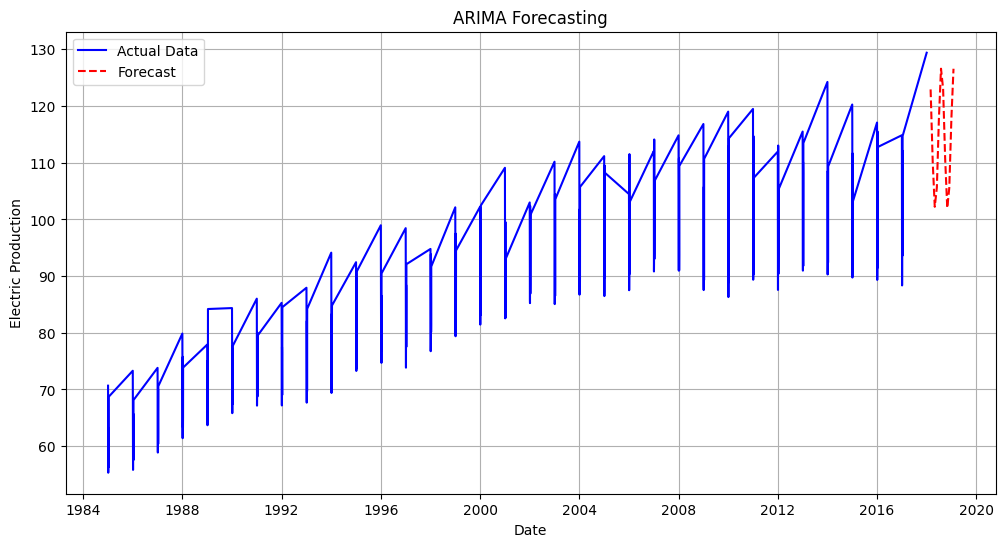

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

# Install missing dependencies
try:
    from statsmodels.tsa.stattools import adfuller, kpss
    from statsmodels.tsa.arima.model import ARIMA
    from pmdarima import auto_arima
except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip install statsmodels pmdarima seaborn
    from statsmodels.tsa.stattools import adfuller, kpss
    from statsmodels.tsa.arima.model import ARIMA
    from pmdarima import auto_arima

warnings.filterwarnings("ignore")

# Load dataset
file_path = "Electric_Production.csv"  # Change this if needed
df = pd.read_csv(file_path)

# Convert DATE column to datetime and set as index
df['DATE'] = pd.to_datetime(df['DATE'], format='%d-%m-%Y', errors='coerce')
df.dropna(subset=['DATE'], inplace=True)  # Remove invalid date formats
df.set_index('DATE', inplace=True)

# Check for missing values and fill them
df['Value'].fillna(method='ffill', inplace=True)

# Function to perform stationarity tests
def stationarity_tests(series):
    """Perform ADF and KPSS tests to check stationarity."""
    adf_test = adfuller(series)
    kpss_test = kpss(series, regression='c', nlags='auto')

    print("\n **ADF Test (Augmented Dickey-Fuller Test):**")
    print(f"Test Statistic: {adf_test[0]}")
    print(f"p-value: {adf_test[1]}")
    print("Stationary" if adf_test[1] < 0.05 else " Non-Stationary")

    print("\n **KPSS Test (Kwiatkowski-Phillips-Schmidt-Shin Test):**")
    print(f"Test Statistic: {kpss_test[0]}")
    print(f"p-value: {kpss_test[1]}")
    print(" Stationary" if kpss_test[1] > 0.05 else " Non-Stationary")

# Run stationarity test
stationarity_tests(df['Value'])

# Apply first-order differencing if data is non-stationary
df['Value_diff'] = df['Value'].diff()
df.dropna(inplace=True)

# Run stationarity test again after differencing
stationarity_tests(df['Value_diff'])

# Find the best ARIMA parameters using auto_arima
auto_model = auto_arima(df['Value'], seasonal=False, stepwise=True, trace=True)
p, d, q = auto_model.order

# Train the ARIMA model
arima_model = ARIMA(df['Value'], order=(p, d, q))
arima_fit = arima_model.fit()

# Forecast for the next 12 months
forecast_steps = 12
forecast = arima_fit.forecast(steps=forecast_steps)

# Plot the original data and forecast
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Value'], label="Actual Data", color='blue')
plt.plot(pd.date_range(start=df.index[-1], periods=forecast_steps+1, freq='M')[1:], forecast, label="Forecast", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Electric Production")
plt.title("ARIMA Forecasting")
plt.legend()
plt.grid()
plt.show()
